In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from helper_utils.utils import *

In [2]:
# LOAD DATA

data_directory = "/Users/varunursekar/Projects/advDeepLearning/bike_share/processed_data/"
data_filename = "X_top300_201701_201912_30_m.npy"

X_raw = np.load(data_directory+data_filename)

Smoothing filter =  [0.01321289 0.26538793 0.72139918]


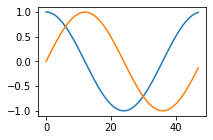

In [3]:
# SMOOTH DATA and ADD TIME INFO

filter_size, filter_type, var = 3, 'gaussian', 1
periods = [2*24,]
num_time_features = max(len(periods),1)

X_raw[:,:,:2] = smooth_counts(X_raw[:,:,:2], filter_size=filter_size, filter_type=filter_type, var=var)
X_raw = add_time_information(X_raw, periods, keep_original_time=False)

plt.figure(figsize=(3,2))
plt.plot(X_raw[0,:48,-1])
plt.plot(X_raw[0,:48,-2])

In [4]:
# TRAIN-TEST SPLIT

window_length = 10
train_pct, valid_pct, test_pct = 0.5, 0.6, 0.8
drop_y_time = True

X, y = make_windows(X_raw, window_length=window_length)

if drop_y_time:
    y = y[:,:,:,:2]

NUM_SAMPLES = len(X)
TRAIN_SAMPLES = int(train_pct*NUM_SAMPLES)
VALID_SAMPLES = int(valid_pct*NUM_SAMPLES)
TEST_SAMPLES = int(test_pct*NUM_SAMPLES)

X_train, y_train = X[:TRAIN_SAMPLES], y[:TRAIN_SAMPLES]
X_val, y_val = X[TRAIN_SAMPLES:VALID_SAMPLES], y[TRAIN_SAMPLES:VALID_SAMPLES]
X_test, y_test = X[VALID_SAMPLES:TEST_SAMPLES], y[VALID_SAMPLES:TEST_SAMPLES]

input_shape = tuple(list(X_train.shape)[1:])
output_shape = tuple(list(y_train.shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

num_nodes, num_steps, input_features = input_shape
_, _, output_features = output_shape

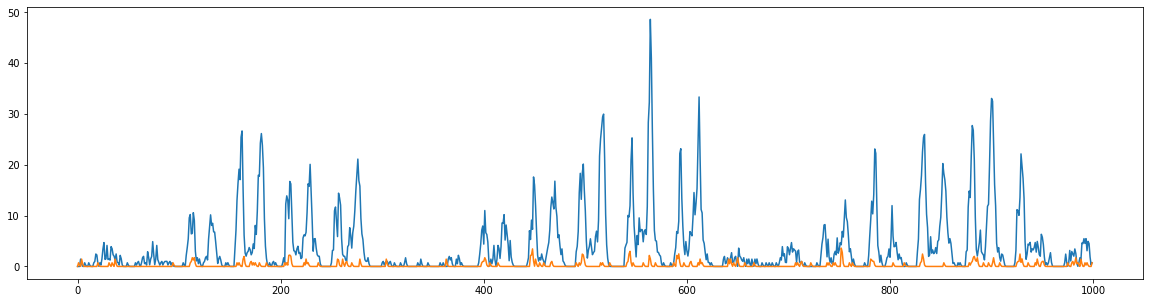

In [5]:
# EXAMPLE PLOT
plt.figure(figsize=(20,5))
plt.plot(X_raw[0,:1000,0])
plt.plot(X_raw[-1,:1000,0])

In [6]:
from models.fnn import FNN
from models.linear import LinearRegressor
from models.fclstm import FCLSTM
from models.stgcn import STGCN
from models.wavenet import GraphWaveNet

In [7]:
model_params = {  'num_layers': 2,
                  'units_per_layer':256,
                  'num_nodes': num_nodes,
                  'num_steps': num_steps,
                  'input_features': input_features,
                  'output_features': output_features,
                  'l2_reg': 0.00}

training_specs = {'model_name': 'FNN',
                  'save_model': False,
                  'save_model_history': False,
                  'model_path': '',
                  'history_path': ''}

BATCH_SIZE = 64
MAX_EPOCHS = 20
PATIENCE = 5
LOSS_TYPE = "mae"
LEARNING_RATE = 1e-3

callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

In [8]:
model = FNN(model_params)

model.compile(loss=LOSS_TYPE, optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
print(model(X_train[:32]).shape)
model.summary()

Metal device set to: Apple M1 Max
(32, 300, 10, 2)
Model: "fnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  10496     
                                                                 
 dense_1 (Dense)             multiple                  65792     
                                                                 
 dense_2 (Dense)             multiple                  5140      
                                                                 
 reshape_1 (Reshape)         multiple                  0         
                                                                 
Total params: 81,428
Trainable params: 81,428
Non-trainable params: 0
_________________________________________________________________


2022-04-23 18:55:14.621218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-23 18:55:14.621344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
history = model.fit(x=X_train, y=y_train, shuffle=True,
                    batch_size=BATCH_SIZE, epochs=MAX_EPOCHS,
                    validation_data=(X_val,y_val),
                    callbacks=[callback_es])

Epoch 1/20


2022-04-23 18:55:15.599511: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/416 [..............................] - ETA: 2:32 - loss: 1.7214

2022-04-23 18:55:15.817737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


415/416 [============================>.] - ETA: 0s - loss: 0.9613

2022-04-23 18:55:21.343785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


416/416 [==============================] - 6s 15ms/step - loss: 0.9616 - val_loss: 1.1758
Epoch 2/20
416/416 [==============================] - 6s 14ms/step - loss: 0.9145 - val_loss: 1.1669
Epoch 3/20
416/416 [==============================] - 6s 14ms/step - loss: 0.9072 - val_loss: 1.1533
Epoch 4/20
416/416 [==============================] - 6s 14ms/step - loss: 0.9034 - val_loss: 1.1583
Epoch 5/20
416/416 [==============================] - 6s 14ms/step - loss: 0.8992 - val_loss: 1.1444
Epoch 6/20
416/416 [==============================] - 6s 14ms/step - loss: 0.8970 - val_loss: 1.1451
Epoch 7/20
416/416 [==============================] - 6s 14ms/step - loss: 0.8952 - val_loss: 1.1436
Epoch 8/20
416/416 [==============================] - 6s 14ms/step - loss: 0.8934 - val_loss: 1.1445
Epoch 9/20
416/416 [==============================] - 6s 14ms/step - loss: 0.8924 - val_loss: 1.1346
Epoch 10/20
416/416 [==============================] - 6s 14ms/step - loss: 0.8915 - val_loss: 1.1405


333/333 [==============================] - 2s 7ms/step - loss: 0.9861
FNN test Loss =  0.9861276149749756


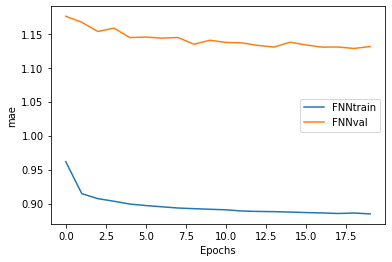

In [10]:
# EVALUATION
plt.figure()
plt.xlabel("Epochs")
plt.ylabel(LOSS_TYPE)
plt.plot(history.history['loss'],label=training_specs['model_name']+'train')
plt.plot(history.history['val_loss'],label=training_specs['model_name']+'val')
plt.legend()

print(training_specs['model_name']+" test Loss = ", model.evaluate(X_test,y_test))

In [11]:
if training_specs['save_model']:
    pass

if training_specs['save_model_history']:
    pass

In [12]:
predictions = model.predict(X_test)
predictions = seq_from_windows(predictions, horizon=0)
ground_truth = seq_from_windows(y_test, horizon=0)

2022-04-23 18:57:13.622020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


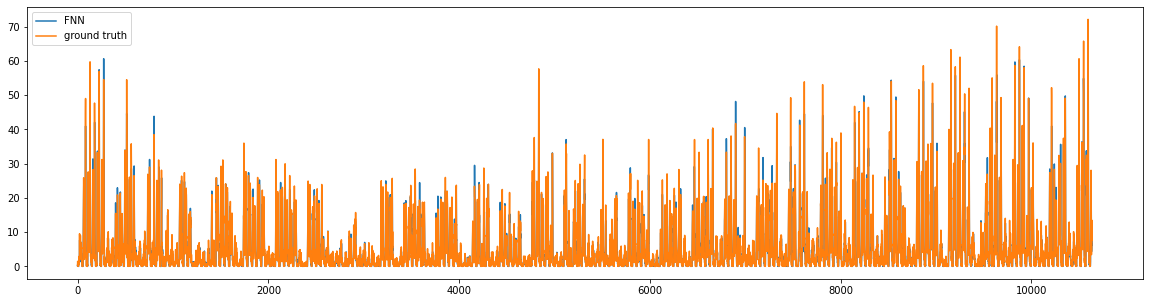

In [13]:
station = 0

plt.figure(figsize=(20,5))
plt.plot(predictions[station,:,0],label=training_specs['model_name'])
plt.plot(ground_truth[station,:,0],label='ground truth')
plt.legend()